# 유기견 입양 프로젝트

CSLEE에서 언어 시각 AI 전문가 양성과정에서 미니프로젝트로 '유기견 입양 프로젝트'를 진행하였습니다.  

유기견을 입양할 때, 개의 품종이 중요하다는 분석결과를 얻어냈습니다.  

그런데 유기견은 품종이 표시되지 않은 것들이 많아서, 이미지로 개의 품종을 분류하는 모델을 만들기로 했습니다. 

Keras API를 사용하여, 딥러닝 모델로 개의 이미지를 품종별로 구별하였습니다.

학습환경은 Kaggle notebook에서 진행하였습니다. (GPU on)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

kaggle 환경 setting 입니다

In [1]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

필요 라이브러리 입니다

## 1. Kaggle image 학습
유기견 이미지만으로는 이미지 퀄리티가 좋지 않았기 때문에 kaggle의 데이터 셋으로 학습을 먼저 합니다.

In [3]:
os.chdir('/kaggle/input/dog-breed-identification/')
labels = pd.read_csv('./labels.csv')
img_path = './train/'
labels = labels.assign(img_path = lambda x : img_path + x['id']+'.jpg')
print("데이터 갯수 :",len(labels))
labels

데이터 갯수 : 10222


,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,./train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./train/0021f9ceb3235effd7fcde7f7538ed62.jpg
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,./train/ffd25009d635cfd16e793503ac5edef0.jpg
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,./train/ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,./train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,./train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg


10222개의 데이터에 id, breed(label값)와 사진의 경로(img_path)를 데이터프레임으로 저장했습니다

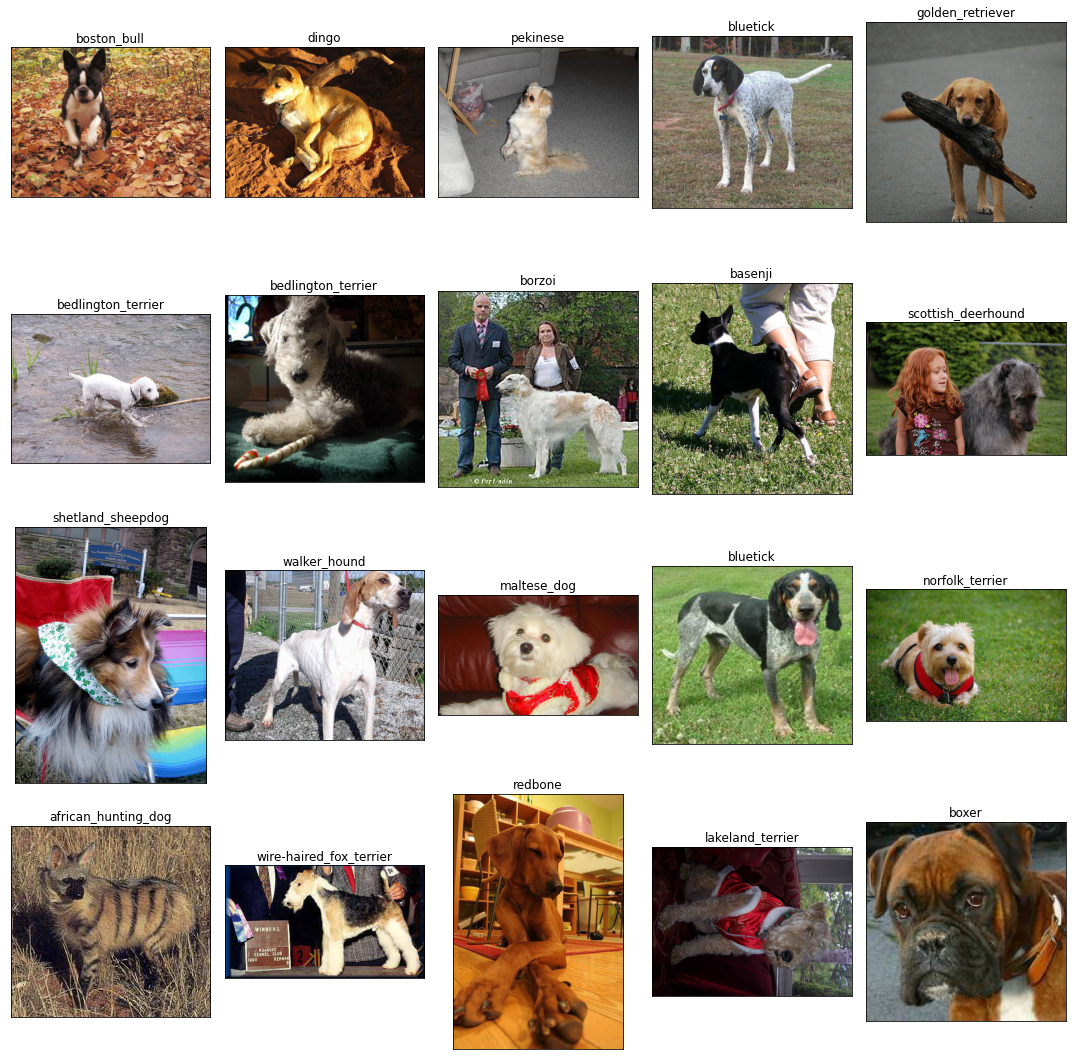

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(labels.img_path[i]))
    ax.set_title(labels.breed[i])
    
plt.tight_layout()
plt.show()


20개의 강아지 사진을 출력해봤습니다. 강아지의 품종과 이미지의 품질이 괜찮다는 것을 확인하였고, 사이즈가 재각각인 것을 고려해야함을 인지하였습니다.

In [5]:
labels = labels.assign(img_path = lambda x : img_path + x['id']+'.jpg')
labels.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

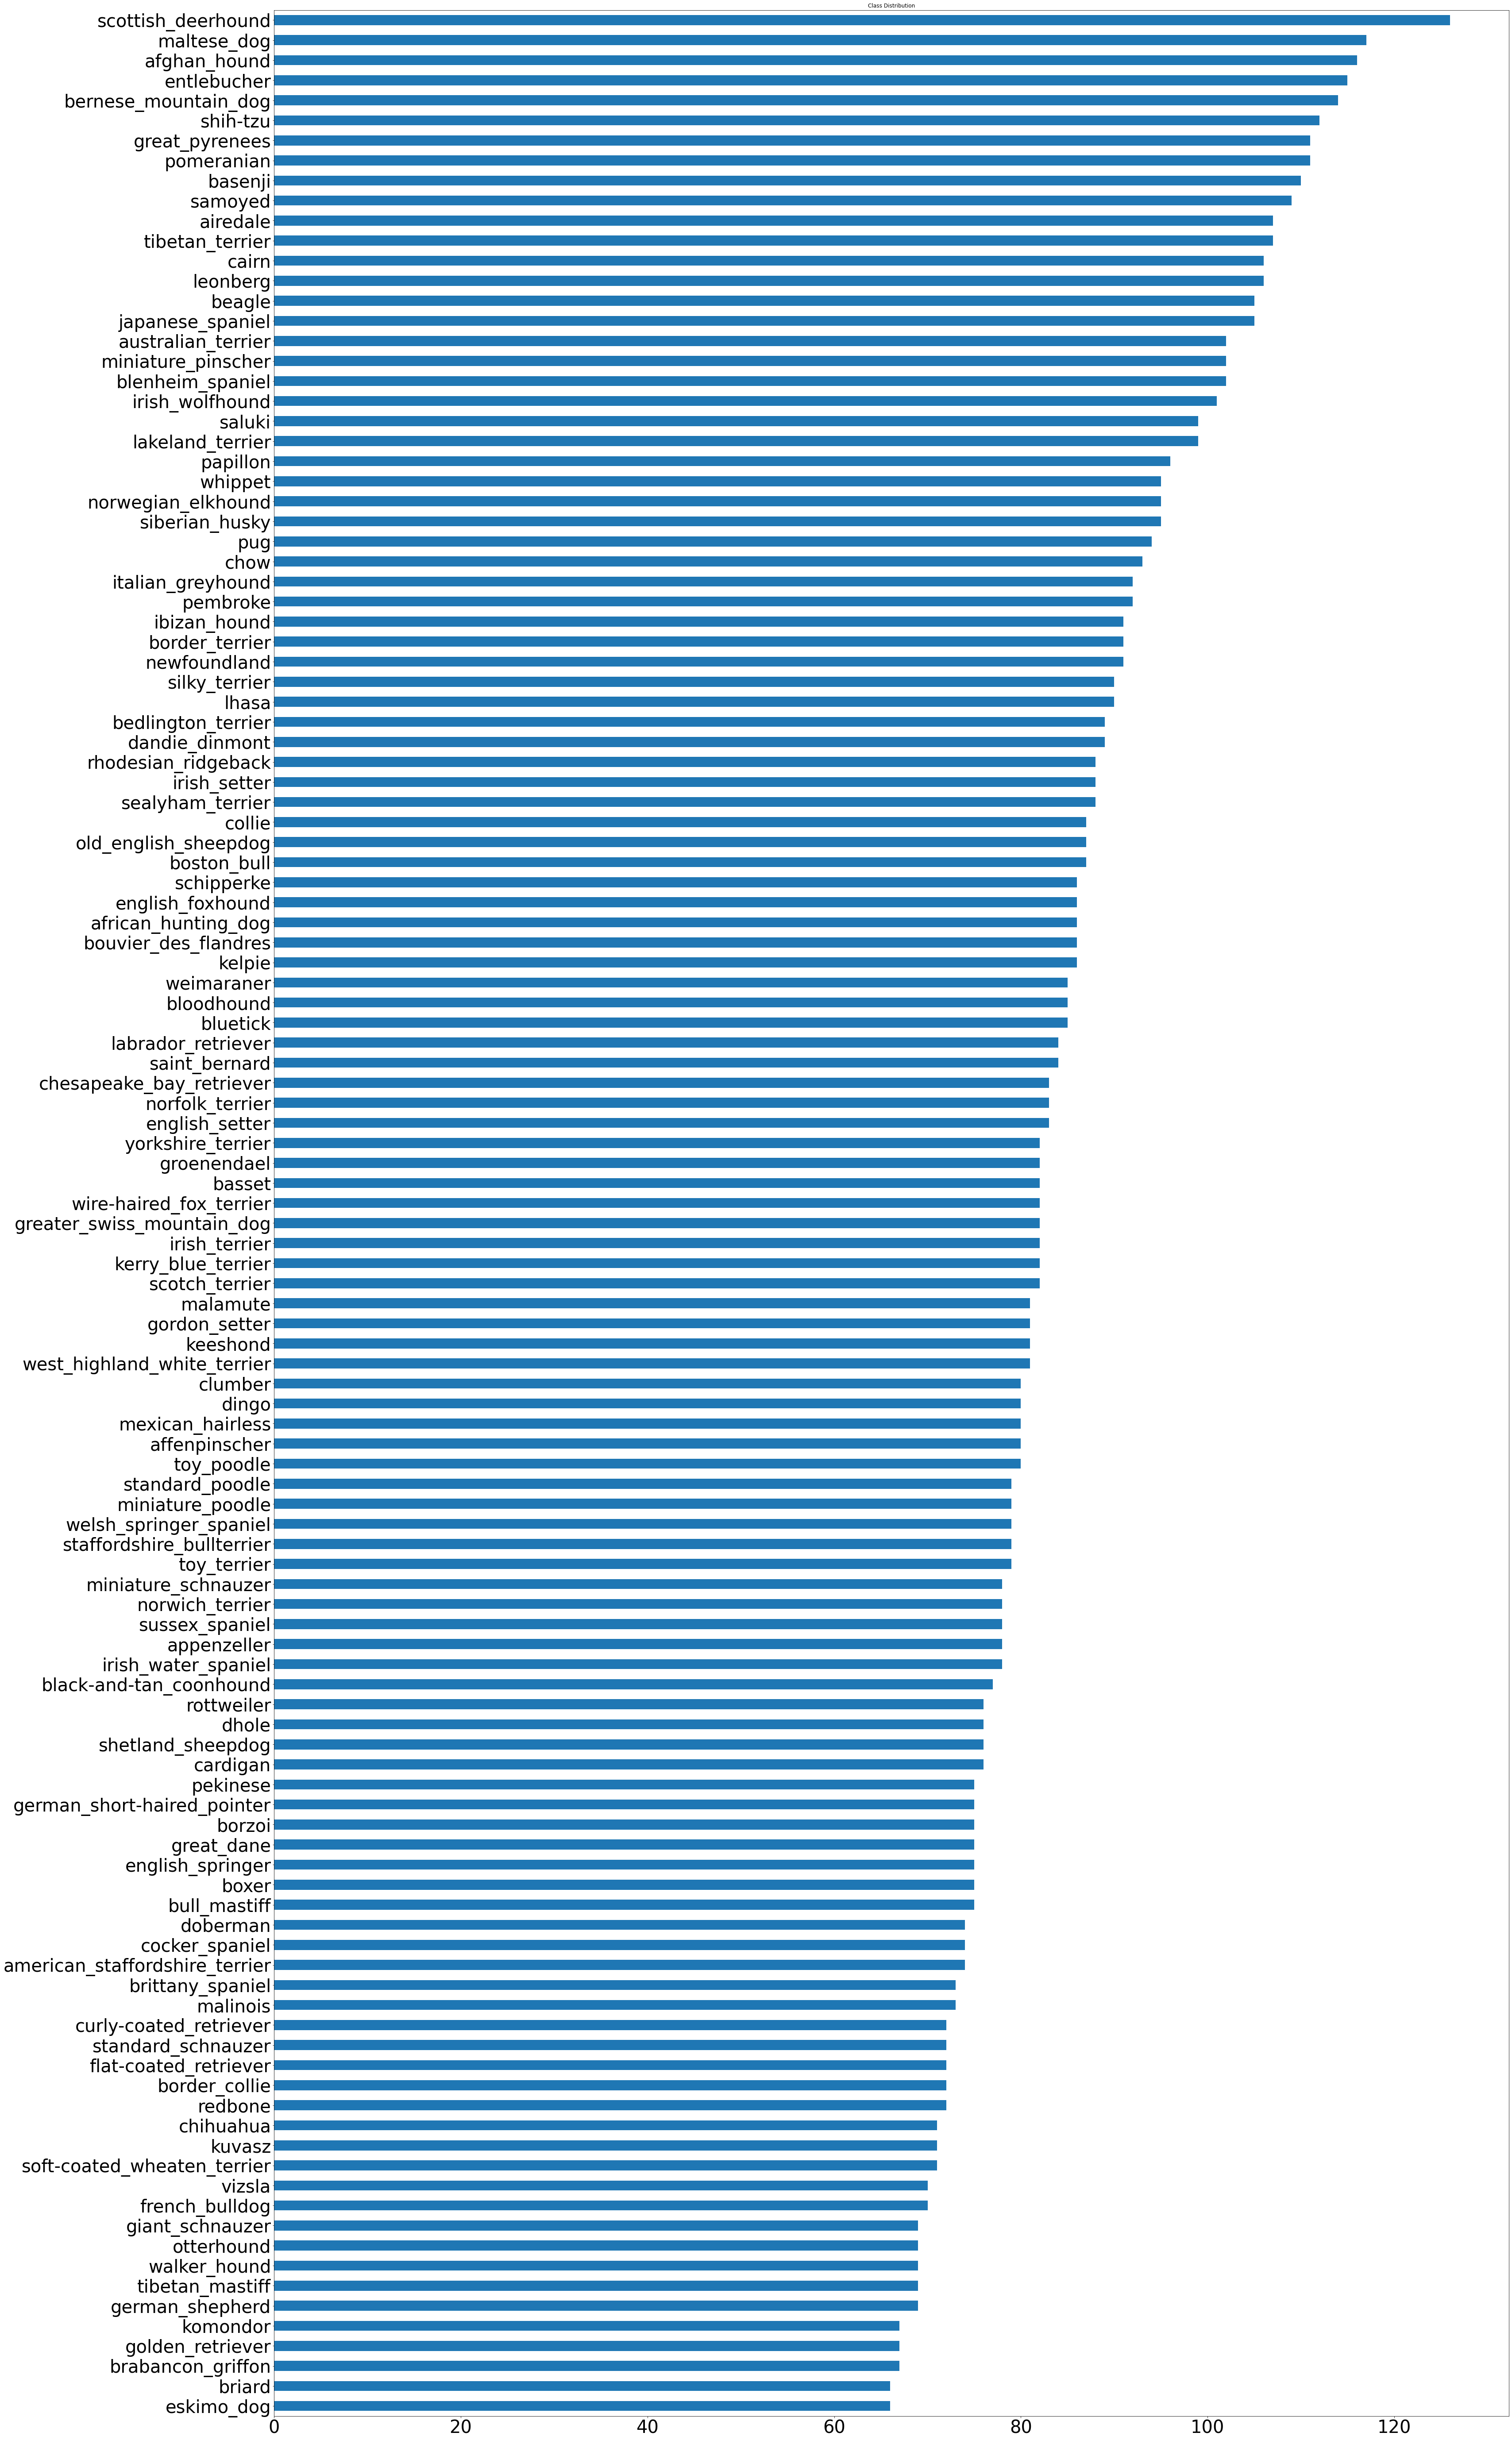

In [6]:
labelplot = pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(50,100))

이미지를 구별하기 위해 모델을 구성할 때, 처음부터 학습하면 시간이 오래걸리기 때문에, 전이학습법을 사용하여 이미지의 feature를 뽑아내고자 했습니다.  

Kaggle에서 keras-pretrained-model이라는, ImageNet 데이터 셋을 가지고 classification을 학습한 weight가 있기 때문에, 이를 가져왔습니다.

In [5]:
!ls ../input/keras-pretrained-models/

Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [6]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [7]:
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

In [8]:
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [411]:
os.chdir("/kaggle/input/dog-breed-identification/")

In [420]:
df = pd.read_csv('labels.csv')
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
#     X[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:00<00:00, 81283.76it/s]


10222장의 이미지를 모두 299 X 299 사이즈로 resize하였습니다. 그리고 라벨은 120종류를 one-hot-encoding으로 표현하였습니다.

In [ ]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    # 우리의 데이터를 사용하기 때문에 include_top =False, weight는 imagenet으로 학습한 것을 가져왔습니다.
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

Keras API를 사용하여,image에서 feature를 뽑아내기 위한 함수 입니다.

In [12]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)
print(inception_features.shape,xception_features.shape)

160/160 [==============================] - 41s 254ms/step
(10222, 2048) (10222, 2048)


In [408]:
features = np.load('../missing-dog/features.npy')
print(features.shape)

(10222, 4096)


GoogLeNet의 종류인 InceptionV3와 Xcetpion를 사용하여 각각의 모델에서 이미지당 2048개씩 feature를 뽑아냈습니다.

In [422]:
features.shape,y.shape

((10222, 4096), (10222, 120))

In [423]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=50, validation_split=0.1)

Epoch 1/50
72/72 [==============================] - 0s 5ms/step - loss: 1.8791 - accuracy: 0.6076 - val_loss: 0.7048 - val_accuracy: 0.8240
Epoch 2/50
72/72 [==============================] - 0s 4ms/step - loss: 0.5778 - accuracy: 0.8415 - val_loss: 0.5410 - val_accuracy: 0.8436
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: 0.4429 - accuracy: 0.8739 - val_loss: 0.5286 - val_accuracy: 0.8299
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: 0.3602 - accuracy: 0.8935 - val_loss: 0.4758 - val_accuracy: 0.8436
Epoch 5/50
72/72 [==============================] - 0s 4ms/step - loss: 0.3016 - accuracy: 0.9151 - val_loss: 0.4626 - val_accuracy: 0.8514
Epoch 6/50
72/72 [==============================] - 0s 4ms/step - loss: 0.2596 - accuracy: 0.9296 - val_loss: 0.4606 - val_accuracy: 0.8495
Epoch 7/50
72/72 [==============================] - 0s 4ms/step - loss: 0.2258 - accuracy: 0.9405 - val_loss: 0.4486 - val_accuracy: 0.8612
Epoch 8/50
72/72 [==

위에서 뽑아낸 4096개의 feature들에 dropout(0.5)을 적용하고, 120개의 ouput으로 classifcation을 하는 모델을 학습했습니다. 

optimizer는 adam, loss는 categorial crossentropy, 지표는 정확도를 사용했으며, validation set은 0.1 비율을 사용했습니다. 

여러번 시도한 결과 epoch을 더 늘리거나, 층수를 더 깊게 쌓아도 큰 변화가 없어서, 한 개의 층, 50 epoch으로 설정하였습니다.

Text(0.5, 0, 'epoch')

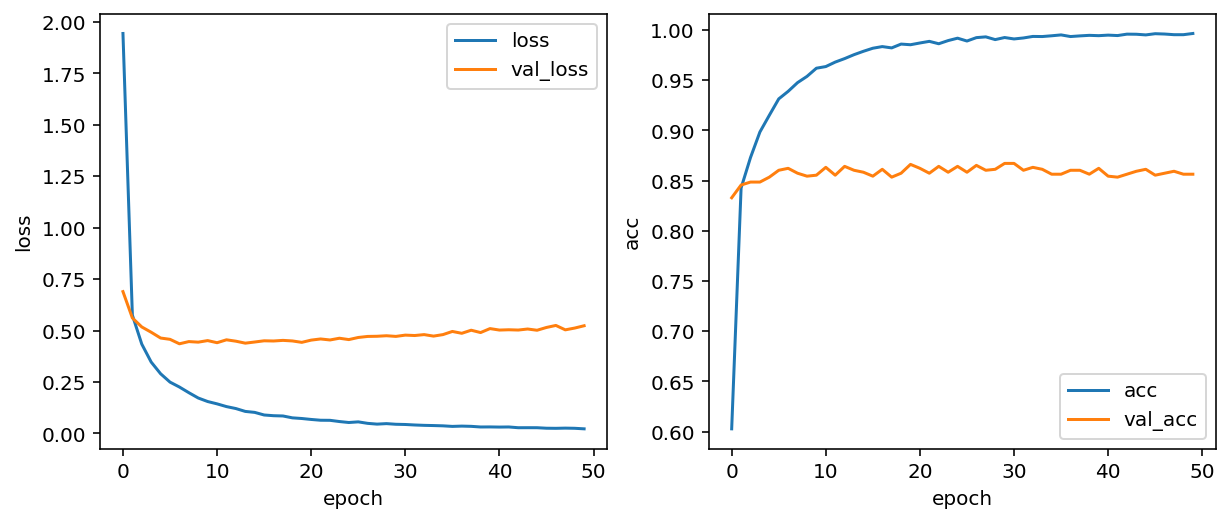

In [16]:
###### import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

학습 그래프 입니다. 120종의 학습을 맞추는 task라서 과적합이 쉽게 일어났지만, validation에서 120종을 85%의 성능으로 맞추는 좋은 성능을 발휘하는 것을 확인하였습니다.

# 2. 유기견에 적용

Kaggle set에서 모델이 잘 동작하는 것을 보고, 우리의 관심 데이터인 유기견  모델에 적용하기로 하였습니다.

In [443]:
os.chdir("/kaggle/input/missing-dog/")

In [13]:
df08_ = pd.read_csv('2019_08.csv')
df09_ = pd.read_csv('2019_08.csv')
df10_ = pd.read_csv('2019_10.csv')

2019.08~10까지의 유기견 데이터 csv 정보를 받아왔습니다.

아래 과정은 위의 kaggle-set전처리와 같습니다.

In [44]:
df08 = df08_.drop([465,3784,5134,7429]) #broken image
df08.reset_index(inplace = True)

In [105]:
n = len(df08)
adoption_info = set(df08['breed'])
n_class = len(adoption_info)
class_to_num = dict(zip(adoption_info,range(n_class)))
width = 299
X1 = np.zeros((n, width, width, 3), dtype=np.uint8)
y1 = np.zeros((n, n_class), dtype=np.uint8)
print("X's shape:",X1.shape,"\ny's shape:",y1.shape)

X's shape: (7723, 299, 299, 3) 
y's shape: (7723, 16)


In [107]:
for i in tqdm(range(n)):
    #X[i] = cv2.resize(cv2.imread('2019_08/%s.jpg' % df08['notice_num'][i]), (width, width))
    y1[i][class_to_num[df08['breed'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7723/7723 [00:00<00:00, 78789.60it/s]


In [17]:
df10 = df10_.drop([631,2093,2588,4301,5324,5325,5557,7082,7083,7084,7085]) # broken image
df10.reset_index(inplace = True)

In [133]:
n = len(df10)
adoption_info = set(df10['breed'])
n_class = len(adoption_info)
class_to_num = dict(zip(adoption_info,range(n_class)))
width = 299
X2 = np.zeros((n, width, width, 3), dtype=np.uint8)
y2 = np.zeros((n, n_class), dtype=np.uint8)
print("X2's shape:",X2.shape,"\ny2's shape:",y2.shape)

X2's shape: (7075, 299, 299, 3) 
y2's shape: (7075, 16)


In [135]:
for i in tqdm(range(n)):
    #X2[i] = cv2.resize(cv2.imread('2019_10/%s.jpg' % df10['notice_num'][i]), (width, width))
    y2[i][class_to_num[df10['breed'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7075/7075 [00:00<00:00, 79731.26it/s]


In [359]:
X_dog = np.concatenate([X1, X2], axis=0)
y_dog = np.concatenate([y1, y2], axis=0)

In [ ]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features1 = np.concatenate([inception_features, xception_features], axis=-1)
print(inception_features.shape,xception_features.shape,features1.shape)
inception_features2 = get_features(InceptionV3, X2)
xception_features2 = get_features(Xception, X2)
features2 = np.concatenate([inception_features2, xception_features2], axis=-1)
print(inception_features2.shape,xception_features2.shape,features2.shape)
# np.save('/kaggle/working/features1',features1)
# np.save('/kaggle/working/features2',features2)

In [445]:
features = np.concatenate([features1,features2],axis=0)
y_dog= np.concatenate([y1,y2],axis=0)

In [367]:
n = len(df08)
breed = set(df08['adoption_info'])
n_class = len(breed)
class_to_num = dict(zip(breed,range(n_class)))
width = 299
yk_1 = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    yk_1[i][class_to_num[df08['adoption_info'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7723/7723 [00:00<00:00, 80740.51it/s]


In [368]:
n = len(df10)
breed = set(df10['adoption_info'])
n_class = len(breed)
class_to_num = dict(zip(breed,range(n_class)))
width = 299
yk_2 = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    yk_2[i][class_to_num[df10['adoption_info'][i]]] = 1 # adoption label 뒤집힘

100%|██████████| 7075/7075 [00:00<00:00, 80593.75it/s]


In [369]:
yk = np.concatenate([yk_1,yk_2],axis=0)

In [ ]:
X = np.zeros((n, width, width, 3), dtype=np.uint8)
yk = np.zeros((n, n_class), dtype=np.uint8)

In [27]:
#df08['breed'].value_counts()
df10['breed'].value_counts()

2     5662
3      304
4      303
1      179
25     106
15      87
13      87
12      71
5       57
7       55
8       46
9       33
35      31
10      20
47      19
26      15
Name: breed, dtype: int64

개의 품종 분포입니다. mixed : 2 로 표시된 것들은 쓸 수 없는 데이터여서, 이를 제외한 품종을 구별하기로 했습니다.

# Nomix classification

In [72]:
df08_nomix = df08[df08['breed']!=2]
df10_nomix = df10[df10['breed']!=2]

In [238]:
def makedata(df_nomix,df_y,feature):
    n = len(df_nomix)
    breed = set(df_nomix['breed'])
    n_class = len(breed)
    class_to_num = dict(zip(breed,range(n_class)))
    Xmx = np.zeros((n,4096), dtype=np.float32)
    ymx = np.zeros((n, n_class+1), dtype=np.uint8)
    m = 0
    for i in list(df_nomix.index):
        Xmx[m] = feature[i]
        ymx[m] = df_y[i]
        m += 1
    ymx = np.delete(ymx,(1),axis=1)
    return Xmx,ymx

In [239]:
Xmx1,ymx1 = makedata(df08_nomix,y1,features1)
Xmx2,ymx2 = makedata(df10_nomix,y2,features2)

In [240]:
Xmx = np.concatenate([Xmx1,Xmx2],axis=0)
ymx = np.concatenate([ymx1,ymx2],axis=0)

In [241]:
df10_nomix

,index,notice_num,breed,sex,weight,age,adoption_info
6,6,공고번호-경남-사천-2019-00927 분실된동물사진,3,2,5.00,1,0
7,7,공고번호-강원-원주-2019-01065 분실된동물사진,4,1,5.30,8,0
8,8,공고번호-강원-원주-2019-01064 분실된동물사진,3,1,3.10,6,0
9,9,공고번호-강원-원주-2019-01063 분실된동물사진,1,1,21.00,5,0
10,10,공고번호-서울-도봉-2019-00218 분실된동물사진,5,1,17.60,7,0
...,...,...,...,...,...,...,...
7065,7072,공고번호-울산-울주-2019-00570 분실된동물사진,25,1,2.00,1,1
7071,7078,공고번호-인천-서구-2019-01018 분실된동물사진,12,2,2.10,5,1
7072,7079,공고번호-대구-달성-2019-00857 분실된동물사진,1,2,3.25,1,0
7073,7080,공고번호-대구-서구-2019-00573 분실된동물사진,15,1,6.80,4,1


2019_10월 유기견 데이터입니다. breed==2(mixed)인 정보를 제외하고, 전처리 과정을 거친 데이터프레임 입니다.

In [437]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)
x = Dense(300, activation='sigmoid')(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)
x = Dense(15, activation='softmax')(x)

model_my = Model(inputs, x)
model_my.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model_my.fit(Xmx, ymx, batch_size=128, epochs=200, validation_split=0.1)

Epoch 1/500
23/23 [==============================] - 0s 13ms/step - loss: 5.9929 - accuracy: 0.1530 - val_loss: 2.5318 - val_accuracy: 0.0219
Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 3.9109 - accuracy: 0.3380 - val_loss: 1.7709 - val_accuracy: 0.4295
Epoch 3/500
23/23 [==============================] - 0s 6ms/step - loss: 3.1632 - accuracy: 0.4373 - val_loss: 1.3459 - val_accuracy: 0.6458
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 2.8151 - accuracy: 0.4913 - val_loss: 1.1457 - val_accuracy: 0.6928
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 2.3867 - accuracy: 0.5300 - val_loss: 1.0388 - val_accuracy: 0.6991
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 2.2067 - accuracy: 0.5429 - val_loss: 0.9590 - val_accuracy: 0.7179
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 2.0259 - accuracy: 0.5711 - val_loss: 0.9060 - val_accuracy: 0.7179
Epoch 8/500


Epoch 59/500
23/23 [==============================] - 0s 8ms/step - loss: 0.6943 - accuracy: 0.7857 - val_loss: 0.6378 - val_accuracy: 0.8245
Epoch 60/500
23/23 [==============================] - 0s 7ms/step - loss: 0.7109 - accuracy: 0.7770 - val_loss: 0.6347 - val_accuracy: 0.8245
Epoch 61/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6849 - accuracy: 0.7840 - val_loss: 0.6316 - val_accuracy: 0.8150
Epoch 62/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6838 - accuracy: 0.7889 - val_loss: 0.6337 - val_accuracy: 0.8182
Epoch 63/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6569 - accuracy: 0.7937 - val_loss: 0.6321 - val_accuracy: 0.8150
Epoch 64/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6528 - accuracy: 0.7976 - val_loss: 0.6262 - val_accuracy: 0.7994
Epoch 65/500
23/23 [==============================] - 0s 6ms/step - loss: 0.7062 - accuracy: 0.7801 - val_loss: 0.6180 - val_accuracy: 0.8119
Epoch 

23/23 [==============================] - 0s 6ms/step - loss: 0.4929 - accuracy: 0.8380 - val_loss: 0.6773 - val_accuracy: 0.8150
Epoch 174/500
23/23 [==============================] - 0s 5ms/step - loss: 0.5102 - accuracy: 0.8387 - val_loss: 0.7043 - val_accuracy: 0.8119
Epoch 175/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4660 - accuracy: 0.8547 - val_loss: 0.6881 - val_accuracy: 0.8150
Epoch 176/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4950 - accuracy: 0.8380 - val_loss: 0.6842 - val_accuracy: 0.8213
Epoch 177/500
23/23 [==============================] - 0s 8ms/step - loss: 0.4742 - accuracy: 0.8446 - val_loss: 0.6777 - val_accuracy: 0.8150
Epoch 178/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4407 - accuracy: 0.8505 - val_loss: 0.6965 - val_accuracy: 0.8150
Epoch 179/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4743 - accuracy: 0.8453 - val_loss: 0.7156 - val_accuracy: 0.8088
Epoch 180/500

23/23 [==============================] - 0s 7ms/step - loss: 0.4613 - accuracy: 0.8554 - val_loss: 0.6785 - val_accuracy: 0.8150
Epoch 288/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4467 - accuracy: 0.8589 - val_loss: 0.6782 - val_accuracy: 0.8119
Epoch 289/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4233 - accuracy: 0.8599 - val_loss: 0.6733 - val_accuracy: 0.8245
Epoch 290/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4215 - accuracy: 0.8620 - val_loss: 0.6607 - val_accuracy: 0.8276
Epoch 291/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4274 - accuracy: 0.8585 - val_loss: 0.6748 - val_accuracy: 0.8276
Epoch 292/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4314 - accuracy: 0.8603 - val_loss: 0.6766 - val_accuracy: 0.8182
Epoch 293/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4230 - accuracy: 0.8582 - val_loss: 0.6708 - val_accuracy: 0.8213
Epoch 294/500

23/23 [==============================] - 0s 5ms/step - loss: 0.3909 - accuracy: 0.8763 - val_loss: 0.7362 - val_accuracy: 0.8182
Epoch 402/500
23/23 [==============================] - 0s 5ms/step - loss: 0.3728 - accuracy: 0.8763 - val_loss: 0.7456 - val_accuracy: 0.8245
Epoch 403/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4255 - accuracy: 0.8603 - val_loss: 0.7292 - val_accuracy: 0.8182
Epoch 404/500
23/23 [==============================] - 0s 6ms/step - loss: 0.4092 - accuracy: 0.8672 - val_loss: 0.7272 - val_accuracy: 0.8213
Epoch 405/500
23/23 [==============================] - 0s 5ms/step - loss: 0.3975 - accuracy: 0.8728 - val_loss: 0.7251 - val_accuracy: 0.8150
Epoch 406/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4044 - accuracy: 0.8707 - val_loss: 0.7327 - val_accuracy: 0.8182
Epoch 407/500
23/23 [==============================] - 0s 5ms/step - loss: 0.4103 - accuracy: 0.8704 - val_loss: 0.7461 - val_accuracy: 0.8182
Epoch 408/500

Text(0.5, 0, 'epoch')

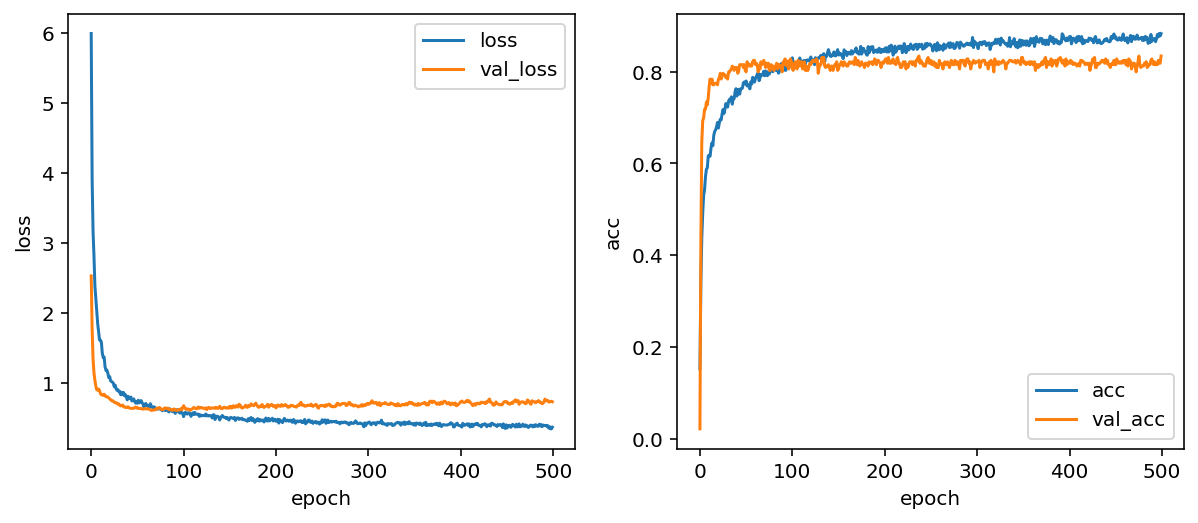

In [438]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [439]:
max(h.history['val_accuracy'])

0.8338558077812195

여러개의 모델을 테스트 해봤고, 가장 높은 정확도를 가진 모델입니다. 이미지의 품질이 좋지 않았기 때문에, 약 83퍼센트의 validation accuracy를 기록했습니다. 

top-3 accuracy는 97퍼센트를 기록하였습니다.